# Optimal Stopping
This demonstrates using Z3 for a simple Optimal Stopping problem. The rules of the game are

* a miner produces one gold per unit of time
* it costs 6 gold to buy a miner
* you cannot ever have negative gold
* you start with 6 gold and 0 miners
* what is the maximum amount of gold you can get after 20 units of time?

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import z3

To formulate this problem we use
* `gold` is the z3 variables for how much gold we have at each unit of time
* `miners` is just an array of expressions of how many workers we have at each unit of time
* `miner_starts` is the start time of each miner

In [2]:
# constants
tmax = 20
miner_cost = 6
start_miners = 0
start_gold = 6
# we have to pick an upper bound on how many miners there can be
max_miners = 6
available_miners = max_miners - start_miners

solver = z3.Solver()

# the amount of gold at time t, gold[tmax-1] is the objective
# these are dependent variables
gold = [z3.Int('gold[%d]'%t) for t in range(tmax)]

# we use this to hold expressions for the number of miners at time t
miners = [None for t in range(tmax)]
# the start time of each miner, these are the independent variables
miner_starts = [z3.Int('miner_start[%s]'%n) for n in range(available_miners)]

Miners must start between 0 and tmax (tmax means never).  For each time t, the gold is equal to the balance of gold in the previous unit of time plus the income of how many miners we currently have plus the amount we paid to buy any more miners.

In [3]:
for i, miner_start in enumerate(miner_starts):
    # miner start times should be in ascending order
    if i>0:
        solver.add(miner_start >= miner_starts[i-1])
    # start time of tmax means never started
    solver.add(miner_start > 0, miner_start < tmax + 1)


solver.add(gold[0] == start_gold)
for t in range(tmax):
    miners[t] = start_miners + z3.Sum([z3.If(t > m, 1, 0) for m in miner_starts])
    if t > 0:
        solver.add(gold[t] > -1)
        purchase_costs = []
        for m in miner_starts:
            purchase_costs.append(z3.If(t == m, miner_cost, 0))
        balance = gold[t-1]
        income = miners[t]
        solver.add(gold[t] == balance + income - z3.Sum(purchase_costs))


In [4]:
# start with a very achievable goal
# and slowly increase it
goal = start_gold
while True:
    solver.push()
    solver.add(gold[tmax-1] > goal)
    s = solver.check()
    if s != z3.sat:
        break
    prev_model = solver.model()
    goal = prev_model[gold[tmax-1]]
    solver.pop()

In [6]:
# clean up data for easily visualization
solution = {str(s): prev_model[s].as_long() for s in prev_model}
golds = [solution['gold[%d]'%t] for t in range(tmax)]
miners_startss = [solution['miner_start[%d]'%x] for x in range(available_miners) if solution['miner_start[%d]'%x] != tmax]
current_miners = [len([y for y in filter(lambda x:x<t, miners_startss)]) for t in range(tmax)]

max gold: 28
max miners: 4


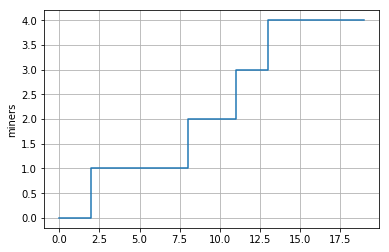

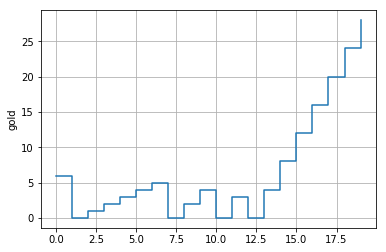

In [13]:
plt.grid(True)
plt.plot(current_miners, drawstyle='steps-post')
plt.ylabel('miners')
plt.figure(2)
plt.grid(True)
plt.plot(golds, drawstyle='steps-post')
plt.ylabel('gold');
print('max gold:', golds[-1])
print('max miners:', current_miners[-1])